# **SNR comparison**
---
#### Overview
- Calculate spectral signal-to-noise ratio (SSNR) for different detection methods (BSD, SE, ADF-STEM, OSTEM)
- Compare results
- Plot images for selected dwell times

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import img_as_float
import tifffile as tf
import pandas as pd
from tqdm.notebook import tqdm

#Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
# Import ssnr code
import ssnr

# Configs
%config Completer.use_jedi = False
pd.set_option("display.max_rows", None)

## 1. Load all image data
---

In [6]:
# Find directory
DATA_dir = Path("../data/3_SNR-comparison-detectors/")

# Select files and initialize DataFrame with image locations
files = [fn for fn in DATA_dir.glob('*/*/*.tif') 
         if not fn.parent.name == '_Qualitative']
df_im = pd.DataFrame({'FilePos': files})

# Build up DataFrame
df_im['DetectionMode'] = df_im['FilePos'].apply(lambda x: x.parent.name.split('_')[0])
df_im['Mode'] = df_im['FilePos'].apply(lambda x: x.parents[1].name)
df_im['LE'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[1].split('kV')[0])
df_im['Dwell'] =  df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im['Dwell'] = df_im['Dwell'].astype(float)
df_im = df_im.sort_values(['DetectionMode', 'Dwell'], ascending=[True, True])

# Preview
df_im.sort_values(['DetectionMode', 'LE'], inplace=True)
df_im.sample(5)

,FilePos,DetectionMode,Mode,LE,Dwell
329,..\data\3_SNR-comparison-detectors\UHR\OSTEM\O...,OSTEM,UHR,4,100.0
134,..\data\3_SNR-comparison-detectors\HR\BSD-SB\B...,BSD-SB,HR,1.5,200.0
73,..\data\3_SNR-comparison-detectors\HR\BSD\BSE_...,BSD,HR,1.5,1000.0
190,..\data\3_SNR-comparison-detectors\HR\OSTEM\OS...,OSTEM,HR,4,300.0
15,..\data\3_SNR-comparison-detectors\HR\ADF-STEM...,ADF-STEM,HR,28,1000.0


## 2. Perform SSNR calculations
---

In [11]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['FilePos','DetectionMode', 'LE', 'Dwell', 'SSNR', 'SNR_Joy'])

# Loop through bioimages
for i, row in tqdm(df_im.iterrows(), total=len(df_im)):

    # Load and crop images
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
    image = image[:1024, :1536]
    
    # Compute SNR from SSNR
    images = ssnr.split_image_rows(image) # Split into rows to avoid streaking effect
    snr = ssnr.SSNR_full(images)
    
    # Compute SNR from Joy 
    snr_joy = ssnr.SNR_JOY(image)

    # Populate DataFrame
    df_snr.loc[i, 'FilePos'] = row['FilePos']
    df_snr.loc[i, 'DetectionMode'] = row['DetectionMode']
    df_snr.loc[i, 'LE'] = row['LE']
    df_snr.loc[i, 'Dwell'] = row['Dwell']
    df_snr.loc[i, 'SSNR'] = snr
    df_snr.loc[i, 'SNR_Joy'] = snr_joy
    df_snr.loc[i, 'Mode'] = row['Mode']
    
# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('DetectionMode')\
      .apply(lambda x: x[::len(df_snr)//10])

  0%|          | 0/395 [00:00<?, ?it/s]

FilePos  \
DetectionMode                                                          
ADF-STEM      24   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              43   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
BSD           76   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              278  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              244  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
BSD-SB        125  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              313  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              114  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
OSTEM         174  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              353  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              316  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
SE            214  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              394  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              358  ..\data\3_SNR-comparison-detectors\SNR-final-c...   

                  DetectionMode   LE    Dwell       SSNR    SNR_Joy Mode  
DetectionMode                                                             
ADF-STEM      24       ADF-STEM   28    100.0   2.675275   2.808229   HR  
              43       ADF-STEM   28   3000.0  22.812647  10.575935   HR  
BSD           76            BSD  1.5    100.0   0.008968   0.051123   HR  
              278           BSD  1.5    500.0   0.006760   0.007192  UHR  
              244           BSD  1.5  10000.0   1.343967   1.030732  UHR  
BSD-SB        125        BSD-SB  1.5    100.0  -0.007550   0.011169   HR  
              313        BSD-SB  1.5    500.0   0.243262   0.223800  UHR  
              114        BSD-SB  1.5  10000.0  14.594629  13.014304   HR  
OSTEM         174         OSTEM    4    100.0   0.212256   0.205962   HR  
              353         OSTEM    4    500.0   0.128093   0.121753  UHR  
              316         OSTEM    4  10000.0   0.972993   0.753642  UHR  
SE            214            SE  1.5    100.0   0.032868   0.030939   HR  
              394            SE  1.5    500.0   0.095453   0.093426  UHR  
              358            SE  1.5  10000.0   2.024598   1.663132  UHR

In [12]:
# Save results
df_snr.to_csv('snr_values.csv',index=True)

### 2.1 (Optionally) load SSNR values to skip computation

In [7]:
df_snr = pd.read_csv('snr_values.csv')
df_snr.groupby('DetectionMode')\
      .apply(lambda x: x[::len(df_snr)//10])

Unnamed: 0  \
DetectionMode                   
ADF-STEM      0            24   
              39           43   
BSD           64           76   
              103         278   
              142         244   
BSD-SB        147         125   
              186         313   
              225         114   
OSTEM         234         174   
              273         353   
              312         316   
SE            315         214   
              354         394   
              393         358   

                                                             FilePos  \
DetectionMode                                                          
ADF-STEM      0    ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              39   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
BSD           64   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              103  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              142  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
BSD-SB        147  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              186  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              225  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
OSTEM         234  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              273  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              312  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
SE            315  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              354  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              393  ..\data\3_SNR-comparison-detectors\SNR-final-c...   

                  DetectionMode    LE    Dwell       SSNR    SNR_Joy Mode  
DetectionMode                                                              
ADF-STEM      0        ADF-STEM  28.0    100.0   2.675275   2.808229   HR  
              39       ADF-STEM  28.0   3000.0  22.812647  10.575935   HR  
BSD           64            BSD   1.5    100.0   0.008968   0.051123   HR  
              103           BSD   1.5    500.0   0.006760   0.007192  UHR  
              142           BSD   1.5  10000.0   1.343967   1.030732  UHR  
BSD-SB        147        BSD-SB   1.5    100.0  -0.007550   0.011169   HR  
              186        BSD-SB   1.5    500.0   0.243262   0.223800  UHR  
              225        BSD-SB   1.5  10000.0  14.594629  13.014304   HR  
OSTEM         234         OSTEM   4.0    100.0   0.212256   0.205962   HR  
              273         OSTEM   4.0    500.0   0.128093   0.121753  UHR  
              312         OSTEM   4.0  10000.0   0.972993   0.753642  UHR  
SE            315            SE   1.5    100.0   0.032868   0.030939   HR  
              354            SE   1.5    500.0   0.095453   0.093426  UHR  
              393            SE   1.5  10000.0   2.024598   1.663132  UHR

## 3. Plot comparison between detection methods
---

In [25]:
# Filter data 
Mode = 'HR' # "HR" or "UHR"
source = df_snr.loc[(df_snr['Mode'].isin([Mode])) &\
                           (df_snr['SSNR'] > 0.001)]\
                      .reset_index()\
                      .copy()
source.sample(5)

,index,Unnamed: 0,FilePos,DetectionMode,LE,Dwell,SSNR,SNR_Joy,Mode
179,307,166,..\data\3_SNR-comparison-detectors\SNR-final-c...,OSTEM,4.0,10000.0,2.700016,2.348646,HR
19,19,15,..\data\3_SNR-comparison-detectors\SNR-final-c...,ADF-STEM,28.0,1000.0,10.267131,9.514364,HR
156,259,193,..\data\3_SNR-comparison-detectors\SNR-final-c...,OSTEM,4.0,300.0,0.236295,0.221793,HR
54,54,2,..\data\3_SNR-comparison-detectors\SNR-final-c...,ADF-STEM,28.0,10000.0,31.953513,27.936140,HR
52,52,0,..\data\3_SNR-comparison-detectors\SNR-final-c...,ADF-STEM,28.0,10000.0,30.507996,20.946243,HR


In [26]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.colors as mcolors
from matplotlib import cycler
import matplotlib as mpl

import matplotlib.ticker as plticker

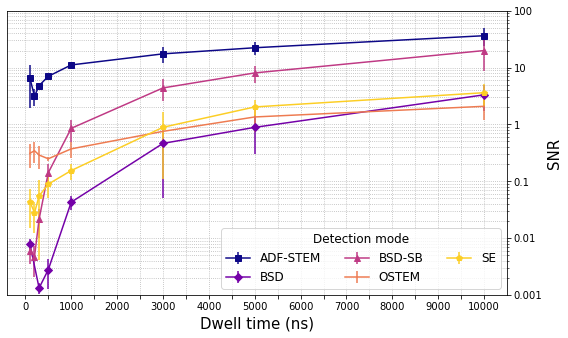

In [29]:
# Make figure

plt.style.use('tableau-colorblind10')
colours = 0.18*len(source.DetectionMode.unique())
cmap = plt.get_cmap('plasma')
#cmap = plt.get_cmap('tableau-colorblind10')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 0.9, len(source['DetectionMode'].unique()))))
fig, ax = plt.subplots(figsize=(8, 4.8)) # 8, 4.8 default
legend = source.DetectionMode.unique()
fs=15 # 15 default
if Mode == 'HR':
    marker=["s","D","^","","p"]
else:
    marker=["D","^","","p"]
# Group by dwell time
for (mode, images), marker in zip(source.groupby(by=['DetectionMode']), marker):
    
    # Calculate mean and std of SSNR
    mean = images.groupby(by=['Dwell'])['SSNR'].mean()
    std = images.groupby(by=['Dwell'])['SSNR'].std()
    
    # Plot 
    ax.errorbar(images.Dwell.unique(), mean, yerr=std, marker=marker, markersize=6, lw=1.5)
    
# Axis aesthetics
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e2])
ax.grid(which='both', ls=':') 
ax.grid(which='both', ls=':') 
ax.legend(legend, title='Detection mode', fontsize=fs-3, title_fontsize=fs-3, loc='lower right', ncol=3)
ax.set_xlabel('Dwell time (ns)',fontsize=fs)
ax.set_ylabel('SNR', fontsize=fs)
for axis in [ax.xaxis, ax.yaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)

# Tidy up axes
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

loc = plticker.MultipleLocator(base=500) # this locator puts ticks at regular intervals, default 500
ax.xaxis.set_major_locator(loc)


for label in ax.yaxis.get_minorticklabels():
    label.set_visible(False) 

for label in ax.xaxis.get_majorticklabels()[0::2]:
    label.set_visible(False)
    
plt.tight_layout()
# plt.savefig(f'SSNR_comparison_{source.Mode.unique()[0]}_paper', dpi=300)

## 4. Plot one image per detection technique per dwell time
---

In [12]:
# Find directory
Mode = 'HR'
DATA_dir = Path(f"../data/3_SNR-comparison-detectors/{Mode}/_Qualitative")

# Select files and initialize DataFrame with image locations
df_qual = pd.DataFrame({'FilePos': list(DATA_dir.glob('*.tif'))})

# Build up DataFrame
df_qual['DetectionMode'] = df_qual['FilePos'].apply(lambda x: x.name.split('_')[0])
df_qual['LE'] = df_qual['FilePos'].apply(lambda x: x.name.split('_')[1])
df_qual['Dwell'] = df_qual['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_qual['Dwell'] = df_qual['Dwell'].astype(float)
df_qual = df_qual.sort_values(['DetectionMode', 'Dwell'], ascending=[True, True])

# Preview
df_qual.sort_values(['DetectionMode', 'LE'], inplace=True)
df_qual.sample(5)

,FilePos,DetectionMode,LE,Dwell
14,..\data\3_SNR-comparison-detectors\HR\_Qualita...,BSD,1.5kV,300.0
24,..\data\3_SNR-comparison-detectors\HR\_Qualita...,SE,1.5kV,300.0
1,..\data\3_SNR-comparison-detectors\HR\_Qualita...,ADF-STEM,28kV,1000.0
23,..\data\3_SNR-comparison-detectors\HR\_Qualita...,SE,1.5kV,3000.0
20,..\data\3_SNR-comparison-detectors\HR\_Qualita...,SE,1.5kV,10000.0


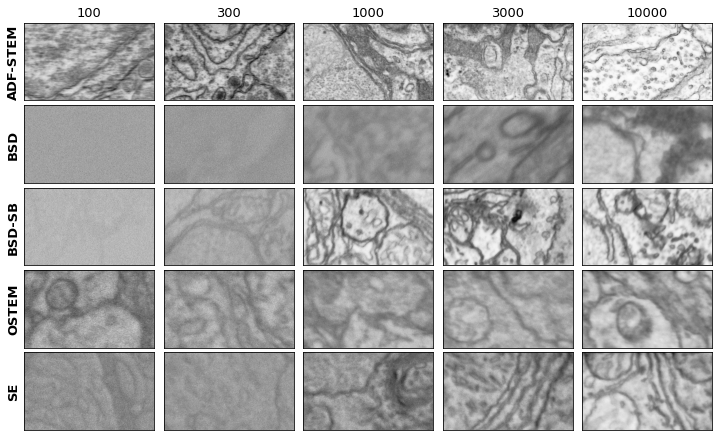

In [23]:
df_qual['Dwell'] = df_qual['Dwell'].astype(int)
source = df_qual.copy()
legend = ['ADF-STEM','BSD','BSD-SB','OSTEM','SE']
fs = 13

# Make figure (Dwell time)
nrows = df_qual['DetectionMode'].unique().size 
ncols = df_qual['Dwell'].unique().size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(2.5*ncols, 1.5*nrows))
plt.subplots_adjust(hspace=0.06)
plt.subplots_adjust(wspace=0.00)
axmap = {k: v for k, v in zip(source['Dwell'].unique(), axes.T)}

# Iterate through subsets of inidivual values for kV
for DT, grp in source.groupby('Dwell'):
    
    ax = axmap[DT]
    # Choose one image per subset (landing energy) to plot
    for k, row in grp.groupby('DetectionMode').apply(lambda x: x).reset_index().iterrows():
        im = img_as_float(tf.imread(row['FilePos'].as_posix()))
        cropped = im[:920,:1536]
        image = ax[k].imshow(cropped, cmap='Greys_r')
        
        # Axes aesthetics
        #ax[k].axis("off")
        ax[k].set_xticks([], [])
        ax[k].set_yticks([], [])
        if DT == 100.0:
            ax[k].set_ylabel(legend[k], fontsize=fs, weight='bold')
    
    # Axes aesthetics
    title = f"{DT}"
    ax[0].set_title(title, fontsize=fs)

# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
# cbar = fig.colorbar(image, cax=cbar_ax)
# plt.savefig(f'im_comparison_{Mode}', dpi=300)